In [1]:
from SloppyCell.ReactionNetworks import *
from NetworkDef import net, MakeProbeNetwork
from DataImport import ImportData
from datetime import date
import numpy as np
import matplotlib.pyplot as plt

defaultfolder = '/Users/Bobby/Dropbox (MIT)/MIT/EnglandGroup/Membranes/Kirchhausen/Data for Bobby/ProbeData02012016/'

class CoatedVesicle:
    """
    Creates network, experiment and model for given lipid probe and optimizable variables.
    
    probe = 'PI3P', 'PI4P' or 'PI34P2'
    
    priors = dictionary specifying prior probabilities. For example, {'ktest' : (3, 1)} would 
    make ktest an optimizable parameter, set 3 as the expected value, and allow the search
    to explore deviations from this value up to a factor of exp(1).
    """
    def __init__(self, probed_lipid, priors = {}, folder = defaultfolder, new_var_vals = {}, 
                 CLTAmax = 70, probemax = 10, filename_params = 'ProbeParams' + str(date.today()) + '.bp',
                filename_ens = 'ProbeEns' + str(date.today()) + '.en', colors = ['red','blue','green']):
        
        self.probed_lipid = probed_lipid
        self.priors = KeyedList(priors.copy())
        self.folder = folder
        self.filename_params = folder + filename_params
        self.filename_ens = folder + filename_ens
        self.colors = colors
        
        self.net_base = net.copy()
        self.net_probe = MakeProbeNetwork(probed_lipid, self.net_base)
        self.net_probe.set_var_vals(new_var_vals)
        self.expt, self.tmin, self.tmax = ImportData(probed_lipid, self.folder, CLTAmax, probemax)
        self.model = Model([self.expt],[self.net_probe])
        for id, val in self.priors.items():
            self.model.set_var_optimizable(id, True)
            self.model.AddResidual(Residuals.PriorInLog('prior_on_%s' % id, id, np.log(val[0]), val[1]))
        self.params = self.model.get_params()
        self.cost = self.model.cost(self.params)
        
    def GetTrajectory(self):
        traj = Dynamics.integrate(self.net_probe, [0, self.tmax])
        return traj
        
    def GetBestFit(self, method = 'Nelder-Mead-log', tol = 1e-3):
        if method == 'Powell-log':
            self.params = Optimization.fmin_powell_log_params(self.model, self.params)
        elif method == 'Nelder-Mead-log':
            self.params = Optimization.fmin_log_params(self.model, self.params, xtol = tol)
        #elif method == 'Nelder-Mead':
        #    self.params = Optimization.fmin(self.model, self.params)
        elif method == 'Levenberg-Marquadt-log':
            self.params = Optimization.fmin_lm_log_params(self.model, self.params)
        elif method == 'Least-Squares-log':
            self.params = Optimization.leastsq_log_params(m, params)
        else:
            print 'Invalid fit method.'

        Utility.save(self.params, self.filename_params)
        self.net_probe.set_var_vals(self.params)
        #self.j, self.jtj = self.model.GetJandJtJ(self.params)
        self.j_log, self.jtj_log = self.model.GetJandJtJInLogParameters(np.log(self.params))
        
    def GetEnsemble(self, maxtime, skip = 0, temperature = 1, plotting = False, load_saved = False):
        if load_saved:
            self.ens, self.F, self.ratio = Utility.load(self.filename_ens)
        else:
            self.ens, self.F, self.ratio = Ensembles.ensemble_log_params(self.model, self.params, max_run_hours = maxtime, 
                                                                     save_to = self.filename_ens, save_hours = 1,
                                                                     skip_elems = skip, temperature = temperature,
                                                                     hess = self.jtj_log)
        
        self.F_autocorr = Ensembles.autocorrelation(self.F)[:round(len(self.F)/2.)]
        
        if plotting:
            fig = plt.figure()
            ax1 = fig.add_subplot(211)
            ax1.plot(self.F)
            ax1.set_xlabel('Steps')
            ax1.set_ylabel('Cost')
            
            cutoff = 0.1
            ax2 = fig.add_subplot(212)
            ax2.plot(self.F_autocorr)
            ax2.set_xlabel('Lag')
            ax2.set_ylabel('Cost Autocorrelation')
    
    def PlotModel(self, datachoice = ['probe']):
        Plotting.figure(1)
        Plotting.plot_model_results(self.model, loc='upper left', data_to_plot = datachoice)
        
    def PlotSensitivity(self, variables, n = [100, 100], var_lims = [[0.1,10],[0.1,10]], nc = 50, ensemble = False):
        self.IntegrateHessian(variables)
        
        var_vals = [self.params.get(variables[0]), self.params.get(variables[1])]
        var_ranges = [var_lims[0][1] - var_lims[0][0], var_lims[1][1] - var_lims[1][0]]
        
        dtheta = np.asarray(var_ranges)*1./np.asarray(n)
        grd = np.mgrid[0:n[0],0:n[1]]
        theta = [grd[0]*dtheta[0] + var_lims[0][0], grd[1]*dtheta[1] + var_lims[1][0]]
        Deltalogtheta = [np.log(theta[0]) - np.log(var_vals[0]), np.log(theta[1]) - np.log(var_vals[1])]
        C = 0.5*self.jtj2_log[0,0]*Deltalogtheta[0]**2 + self.jtj2_log[0,1]*Deltalogtheta[0]*Deltalogtheta[1] + 0.5*self.jtj2_log[1,1]*Deltalogtheta[1]**2
    
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.contour(theta[0], theta[1], C, nc)
        ax.set_xlabel(variables[0])
        ax.set_ylabel(variables[1])
        
        if ensemble:
            theta_ens = []
            for l in range(len(self.ens)):
                ens_params = self.ens[l]
                theta_ens.append([ens_params.get(variables[0]), ens_params.get(variables[1])])
            theta_ens = np.asarray(theta_ens)
            ax.plot(theta_ens[:,0],theta_ens[:,1],'o')
        
        return theta, C
        
    def PlotLipidRange(self, skip = 100):
        self.lipid_traj = []
        self.probe_traj = []
        self.t_traj = []
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        NetName = self.expt.GetData().keys()[0]
        dataDict = self.expt.GetData()[NetName]['probe']
        data = np.array([[t, v, e] for (t, (v, e)) in dataDict.items()])  
        ax.errorbar(data[:,0], data[:,1], yerr=data[:,2], color=self.colors[2], linestyle='', label = 'Probe Data')
        
        for n in range(0,len(self.ens),skip):
            self.net_probe.set_var_vals(self.ens[n])
            traj = self.GetTrajectory()
            lipid = traj.get_var_traj(self.probed_lipid)
            probe = traj.get_var_traj('probe')
            t = traj.get_times()
            roi = t > self.tmin
            
            self.lipid_traj.append(lipid)
            self.probe_traj.append(probe)
            self.t_traj.append(t)
            
            if n == 0:
                ax.plot(t[roi],lipid[roi],'--',label = self.probed_lipid, color = self.colors[0])
                ax.plot(t[roi],probe[roi],label = 'Probe Simulation', color = self.colors[1])
                ax.legend()
            else:
                ax.plot(t[roi],lipid[roi],'--', color = self.colors[0])
                ax.plot(t[roi],probe[roi], color = self.colors[1])

        ax.set_xlabel('t (s)')

    def IntegrateHessian(self, variables):
        n_deleted = 0
        variables_idx = []
        #jtj2 = self.jtj.copy()
        jtj2_log = self.jtj_log.copy()
        
        for item in variables:
            variables_idx.append(self.params.index_by_key(item))

        for var0 in range(np.size(self.jtj_log,0)):
            if var0 not in variables_idx:
                var = var0 - n_deleted
                #a = jtj2[var,var]
                #b = jtj2[:,var]
                #b2 = np.meshgrid(b,b)
                #b2 = b2[0]*b2[0].T
                #jtj2 = jtj2 - b2/a
                #jtj2 = np.delete(jtj2, var, axis = 0)
                #jtj2 = np.delete(jtj2, var, axis = 1)
            
                a_log = jtj2_log[var,var]
                b_log = jtj2_log[:,var]
                b2_log = np.meshgrid(b_log,b_log)
                b2_log = b2_log[0]*b2_log[0].T
                jtj2_log = jtj2_log - b2_log/a_log
                jtj2_log = np.delete(jtj2_log, var, axis = 0)
                jtj2_log = np.delete(jtj2_log, var, axis = 1)
    
                n_deleted += 1
        
        #self.jtj2 = jtj2
        self.jtj2_log = jtj2_log

Failed to import libsbml.
SBML import and export not available.


In [2]:
print test.expt.GetData()['netPI3P']['probe']

NameError: name 'test' is not defined

# Method Tests

In [3]:
test = CoatedVesicle('PI3P', priors = {'N3k0' : (1,100), 'N4k0' : (1,100)}, new_var_vals = {'Nprobe' : 2, 'kcon0' : 0.09, 'kloffPI3P' : 3.2})

## Fitting

Optimization terminated successfully.
         Current function value: 11060.752860
         Iterations: 38
         Function evaluations: 73


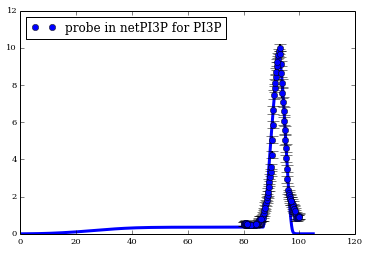

In [4]:
%matplotlib inline
test.GetBestFit()
test.PlotModel()

## Trajectory Plotting

([[<matplotlib.lines.Line2D at 0x10c077bd0>],
 ['PI3P', 'probe'])

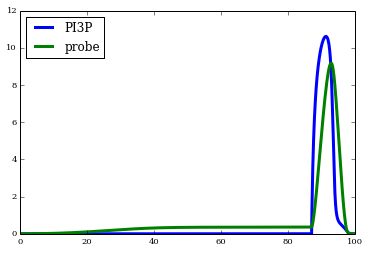

In [5]:
traj = test.GetTrajectory([0,100])
Plotting.figure(1)
Plotting.plot_trajectory(traj, vars = ['PI3P','probe'])

## Agreement between Hessian and JtJ

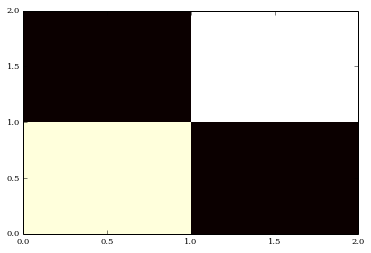

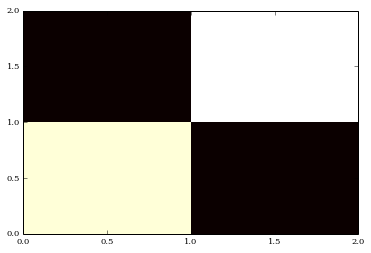

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#j, jtj = test.model.GetJandJtJInLogParameters(np.log(test.params))
#h =  test.model.hessian_log_params(test.params, 0.0001)

j, jtj = test.model.GetJandJtJInLogParameters(np.log(test.params))
h =  test.model.hessian_log_params(test.params, 0.000001)

plt.pcolor(h, cmap = 'hot')
plt.show()
plt.pcolor(jtj, cmap = 'hot')

## Sensitivity Plotting

<matplotlib.contour.QuadContourSet instance at 0x101eb1c20>

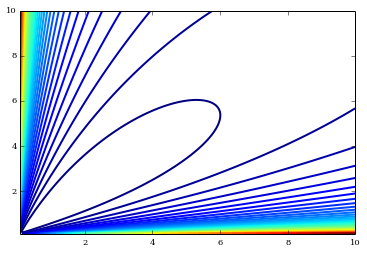

In [21]:
hp = jtj

n1 = 990
n2 = 990
theta10 = 1.06
theta20 = 1.71
dtheta1 = 0.01
dtheta2 = 0.01

grd = np.mgrid[0:n1,0:n2]
theta1 = grd[0]*dtheta1 + 0.1
theta2 = grd[1]*dtheta2 + 0.1

deltheta1 = np.log(theta1) - np.log(0.924)
deltheta2 = np.log(theta2) - np.log(0.999)

C = 0.5*hp[0,0]*deltheta1**2 + hp[0,1]*deltheta1*deltheta2 + 0.5*hp[1,1]*deltheta2**2
plt.contour(theta1,theta2,C,50)

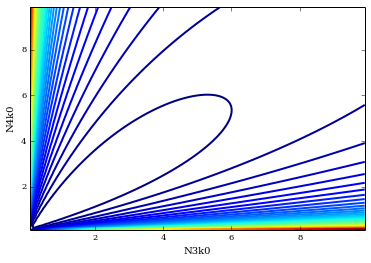

In [20]:
theta, C = test.PlotSensitivity(['N3k0','N4k0'])

## Ensembles

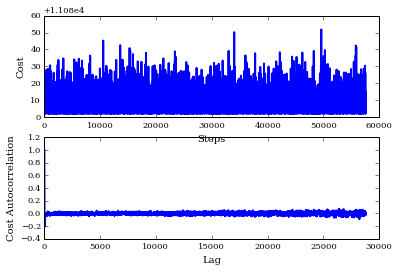

In [5]:
test.GetEnsemble(2, temperature = 5, load_saved = True, plotting = True)

([array([[ 0.85  ,  0.85  ,  0.85  , ...,  0.85  ,  0.85  ,  0.85  ],
         [ 0.8515,  0.8515,  0.8515, ...,  0.8515,  0.8515,  0.8515],
         [ 0.853 ,  0.853 ,  0.853 , ...,  0.853 ,  0.853 ,  0.853 ],
         ..., 
         [ 0.9955,  0.9955,  0.9955, ...,  0.9955,  0.9955,  0.9955],
         [ 0.997 ,  0.997 ,  0.997 , ...,  0.997 ,  0.997 ,  0.997 ],
         [ 0.9985,  0.9985,  0.9985, ...,  0.9985,  0.9985,  0.9985]]),
  array([[ 0.85  ,  0.8525,  0.855 , ...,  1.0925,  1.095 ,  1.0975],
         [ 0.85  ,  0.8525,  0.855 , ...,  1.0925,  1.095 ,  1.0975],
         [ 0.85  ,  0.8525,  0.855 , ...,  1.0925,  1.095 ,  1.0975],
         ..., 
         [ 0.85  ,  0.8525,  0.855 , ...,  1.0925,  1.095 ,  1.0975],
         [ 0.85  ,  0.8525,  0.855 , ...,  1.0925,  1.095 ,  1.0975],
         [ 0.85  ,  0.8525,  0.855 , ...,  1.0925,  1.095 ,  1.0975]])],
 array([[  506.67570392,   476.43702571,   447.31644834, ...,
          1654.56007227,  1699.7172999 ,  1745.39578391],
     

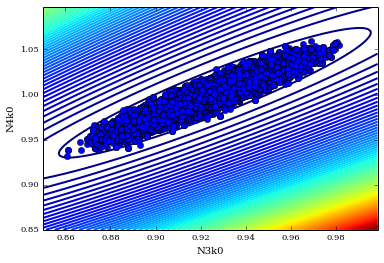

In [10]:
test.PlotSensitivity(['N3k0','N4k0'],ensemble = True,var_lims = [[0.85, 1],[0.85,1.1]], nc = 100)

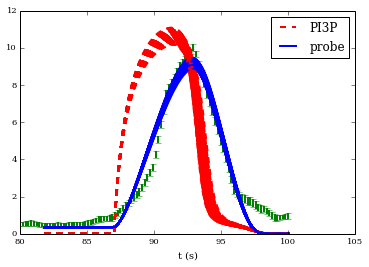

In [6]:
test.PlotLipidRange()